# Posterior Predictive Analysis for GARCH(1,1) Model

-  Step 1: Simulate hypothetical parameters via from posterior distribution via HMC in Stan

- Step 2: Compute simulated data via the likelihood function, conditional on the simulated parameters (in Stan)

- Step 3: Compare simulated data with observed data to validate model

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("Current working directory: ", os.getcwd())

Current working directory:  c:\Users\nklatsky\econometrics\econometrics2024\project\code\garch


## Read in Real Data

In [3]:
# Read in the train-test split 
# Read train_test.csv
train_test_split = pd.read_csv("../../train_test.csv")
train_size = train_test_split['train'][0]
test_size = train_test_split['test'][0]

# Define data path:
data_path = "../../data/DXY_approx_percent_returns.csv"
real_data = pd.read_csv(data_path, index_col=0)
real_data = real_data - np.mean(real_data)

# calculate the splitting point as the train_size * len of data, rounded
split_point = int(train_size * len(real_data))

# Take training data range only
real_data = real_data.iloc[:split_point]
real_data


,DXY
Date,
1994-04-01,-0.435009
1994-05-01,0.030122
1994-06-01,0.247245
1994-07-01,-0.768186
1994-10-01,0.362673
...,...
2018-02-21,0.315110
2018-02-22,-0.294709
2018-02-23,0.162735


In [4]:
# calculate summary stats on real data: mean, std, skew, kurtosis, min, max, .025, .50, .975 quantiles
summary_stats = real_data.describe(percentiles=[.025, .5, .975])
summary_stats


,DXY
count,6241.000000
mean,-0.002077
std,0.498790
min,-3.057377
2.5%,-1.026845
50%,-0.000945
97.5%,1.018463
max,2.518960


## Read in Generated Data

In [5]:
# Read in generated data from prior predictive distribution(y_sim_samples)

garch_y_post_path = "sampler_outputs/y_post_samples.csv"
garch_y_post = pd.read_csv(garch_y_post_path)
garch_y_post

,0,1,2,3,4,5,6,7,8,9,...,6231,6232,6233,6234,6235,6236,6237,6238,6239,6240
0,0.612588,0.052870,-0.645732,1.486150,0.232898,-0.552703,-0.874772,0.193778,0.307079,-0.011716,...,0.134420,-0.228907,-0.067352,-0.399515,-0.026631,-0.724197,-0.182562,-0.434102,0.265978,-0.127841
1,-0.745484,0.202980,1.694700,-0.438466,0.851613,1.421250,0.297579,1.534450,0.179558,0.549813,...,0.207059,-0.348098,0.298412,0.488787,0.526769,0.420520,1.157640,-0.203188,-0.248389,0.441441
2,1.279930,-1.326580,-0.155550,0.590180,-0.224086,-0.404424,-0.836580,-0.522611,-0.214643,-0.204235,...,0.643894,0.929600,0.195849,0.187974,0.009974,-0.509962,0.519602,0.084785,-0.360240,0.730530
3,-1.378820,-1.191150,-1.507050,-0.344787,1.331190,0.459318,1.337320,0.759798,-0.522519,-1.902970,...,-0.253133,0.219227,0.463404,0.155498,0.286923,-0.397817,0.457268,-0.208158,1.101600,0.110628
4,-1.578980,2.069330,-0.012437,-0.025185,0.096150,-0.223265,0.446906,0.938426,-0.593507,-1.105380,...,-0.047593,0.217816,0.057467,1.091410,-0.450156,0.845193,-0.424030,1.133080,-1.031210,0.687524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.305751,0.412320,-0.826637,-1.472520,-0.262425,0.333739,1.072780,0.237541,-0.139201,0.357627,...,-0.710344,-0.094601,-0.144329,0.539397,0.379820,-0.042169,-0.257202,-0.586003,0.629313,-0.553991
3996,-0.234023,1.293110,1.111220,-0.079442,-0.728304,-1.139110,0.976566,0.023963,0.186824,0.729157,...,0.039391,-0.293105,0.216583,1.135470,-0.213506,0.140567,-0.700119,0.037859,-0.186397,0.430832
3997,-0.382484,-0.261342,0.693265,-0.414596,1.337900,-0.196252,0.113258,-0.537427,-0.015204,-1.336170,...,-0.168222,0.442698,0.201271,0.149744,0.004640,-0.312566,-0.166290,0.199487,-0.958295,-0.664901
3998,0.025906,-0.508384,-0.781069,-0.116811,-0.611049,-1.646030,-1.157190,1.308570,0.098339,2.156550,...,0.252288,-0.387414,-0.072663,-0.913161,0.144292,-0.186305,-0.379513,0.310059,0.800402,-0.073639


# Comparison

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting indices for detailed comparison, assuming a larger dataset
indices = [5, 2000, 3000]

# Loop through selected indices
for index in indices:
    real_sample = real_data
    post_sample = garch_y_post.iloc[index]

    # Calculate statistics for the current index
    real_mean = np.mean(real_sample)
    real_std = np.std(real_sample)
    real_skew = real_sample.skew()
    real_kurt = real_sample.kurt()

    post_mean = np.mean(post_sample)
    post_std = np.std(post_sample)
    post_skew = post_sample.skew()
    post_kurt = post_sample.kurt()

    # Print statistics
    print(f"Statistics for Index {index}:")
    print("Real Data Mean: ", real_mean)
    print("Posterior Data Mean: ", post_mean)
    print("Real Data StdDev: ", real_std)
    print("Posterior Data StdDev: ", post_std)
    print("Real Data Skewness: ", real_skew)
    print("Posterior Data Skewness: ", post_skew)
    print("Real Data Kurtosis: ", real_kurt)
    print("Posterior Data Kurtosis: ", post_kurt)
    print("\n")


Statistics for Index 5:
Real Data Mean:  -0.002077034927474549
Posterior Data Mean:  0.0013651440004806904
Real Data StdDev:  DXY    0.49875
dtype: float64
Posterior Data StdDev:  0.5016332348979413
Real Data Skewness:  DXY   -0.128806
dtype: float64
Posterior Data Skewness:  -0.003129265762615821
Real Data Kurtosis:  DXY    1.943165
dtype: float64
Posterior Data Kurtosis:  0.4070070713873548


Statistics for Index 2000:
Real Data Mean:  -0.002077034927474549
Posterior Data Mean:  0.0076403308085242734
Real Data StdDev:  DXY    0.49875
dtype: float64
Posterior Data StdDev:  0.4932081814573
Real Data Skewness:  DXY   -0.128806
dtype: float64
Posterior Data Skewness:  0.08372041120362836
Real Data Kurtosis:  DXY    1.943165
dtype: float64
Posterior Data Kurtosis:  0.38415594204637005


Statistics for Index 3000:
Real Data Mean:  -0.002077034927474549
Posterior Data Mean:  0.002493051057202372
Real Data StdDev:  DXY    0.49875
dtype: float64
Posterior Data StdDev:  0.4910999522208257
Real

c:\Users\nklatsky\econometrics\econometrics2024\myenv\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


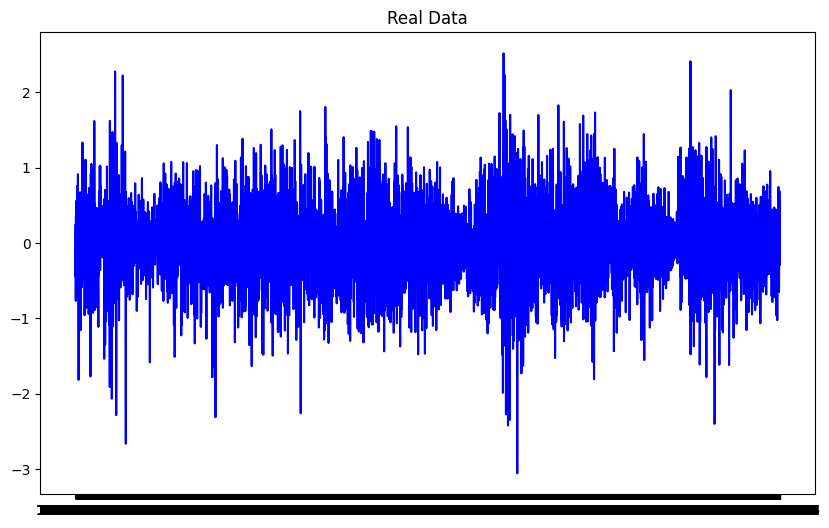

In [7]:
# Plot the real data as a time series
plt.figure(figsize=(10, 6))
plt.plot(real_data, color='blue')
plt.title("Real Data")
plt.show()


In [8]:
garch_y_post.iloc[500]
# real_data.iloc[:,0]

0       1.069170
1      -1.268760
2       0.316882
3      -0.362883
4       1.274110
          ...   
6236    0.330647
6237   -0.447728
6238   -0.789904
6239   -0.562242
6240   -0.300008
Name: 500, Length: 6241, dtype: float64

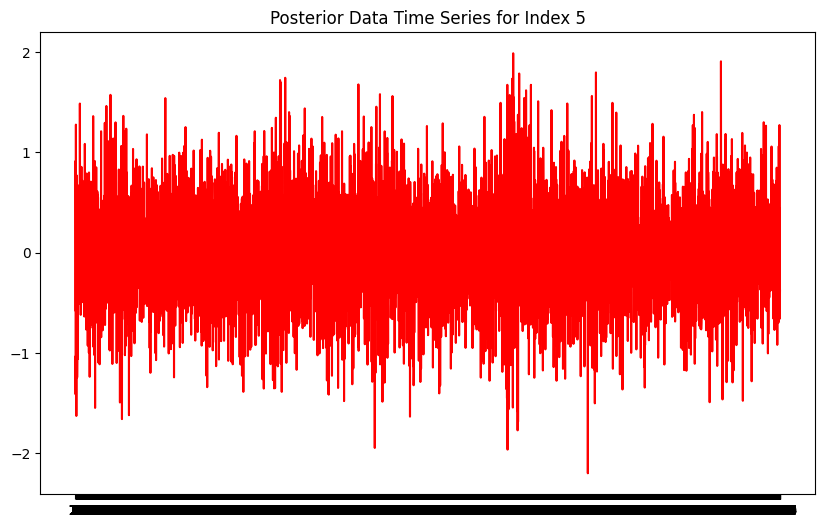

In [9]:
# Plot the posterior data for 3 random indices as a time series
indices = [5]

for index in indices:
    post_sample = garch_y_post.iloc[index]

    plt.figure(figsize=(10, 6))
    plt.plot(post_sample, color='red')
    plt.title(f"Posterior Data Time Series for Index {index}")
    plt.show()
    

Statistics for Index 5:
Real Data Mean:  DXY   -0.002077
dtype: float64
Posterior Data Mean:  0.0013651440004806904
Real Data StdDev:  DXY    0.49879
dtype: float64
Posterior Data StdDev:  0.5016734282584399
Real Data Skewness:  DXY   -0.128806
dtype: float64
Posterior Data Skewness:  -0.003129265762615821
Real Data Kurtosis:  DXY    1.943165
dtype: float64
Posterior Data Kurtosis:  0.4070070713873548




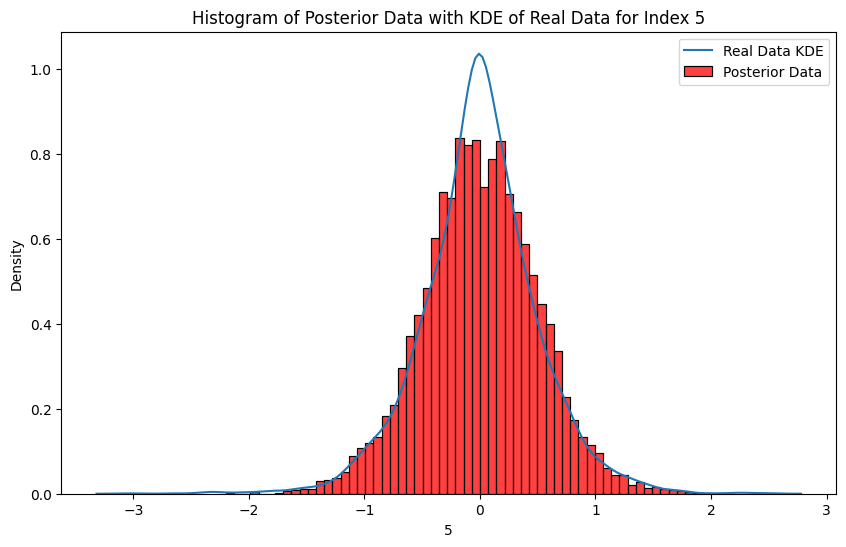

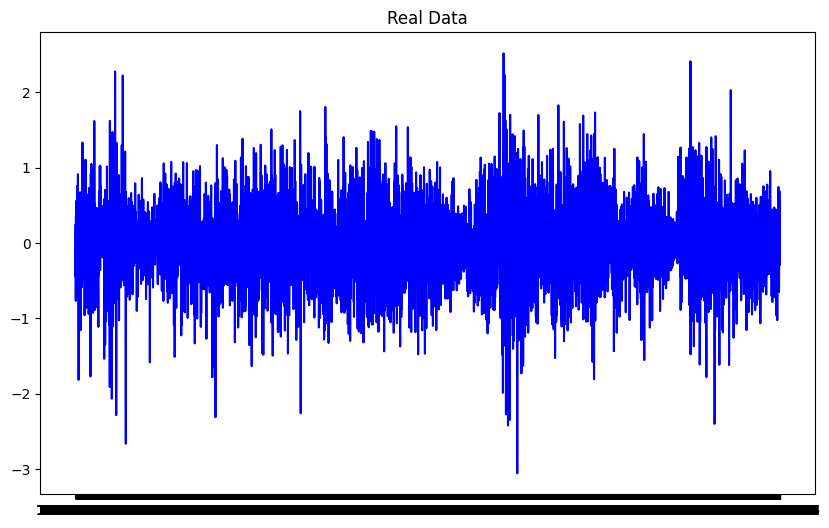

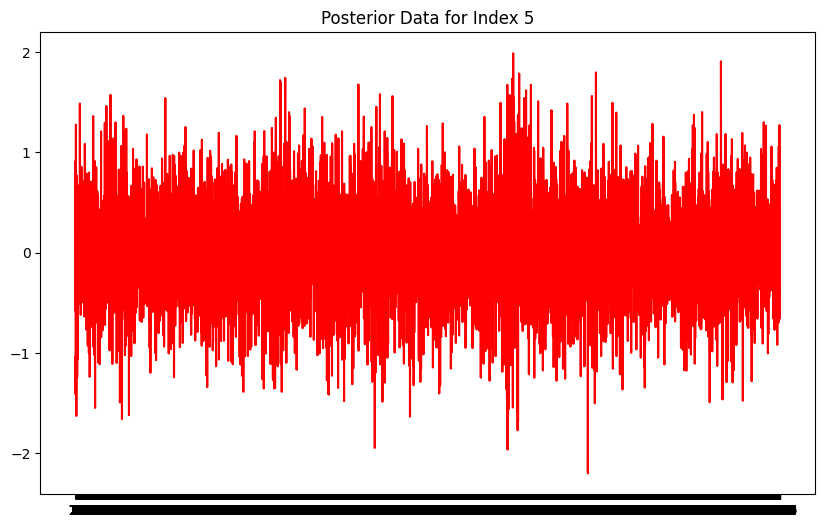

Statistics for Index 3000:
Real Data Mean:  DXY   -0.002077
dtype: float64
Posterior Data Mean:  0.002493051057202372
Real Data StdDev:  DXY    0.49879
dtype: float64
Posterior Data StdDev:  0.4911393016021012
Real Data Skewness:  DXY   -0.128806
dtype: float64
Posterior Data Skewness:  -0.04679204360991069
Real Data Kurtosis:  DXY    1.943165
dtype: float64
Posterior Data Kurtosis:  0.5247186374699715




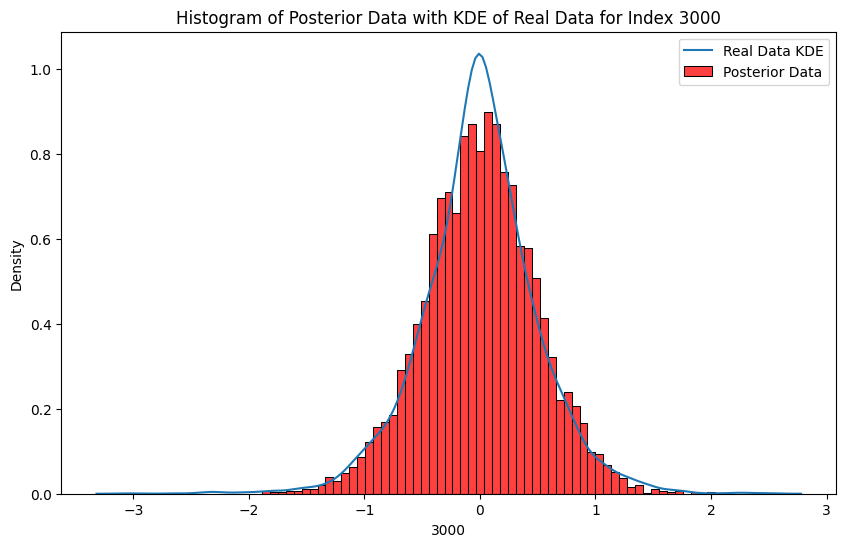

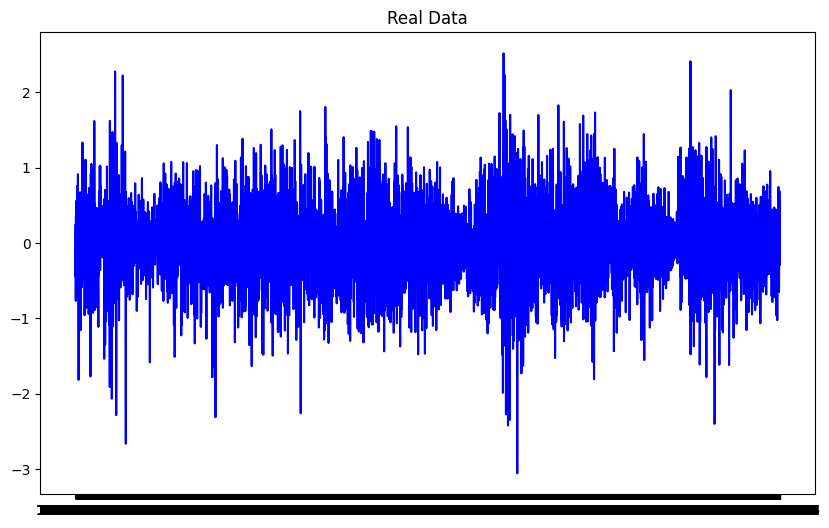

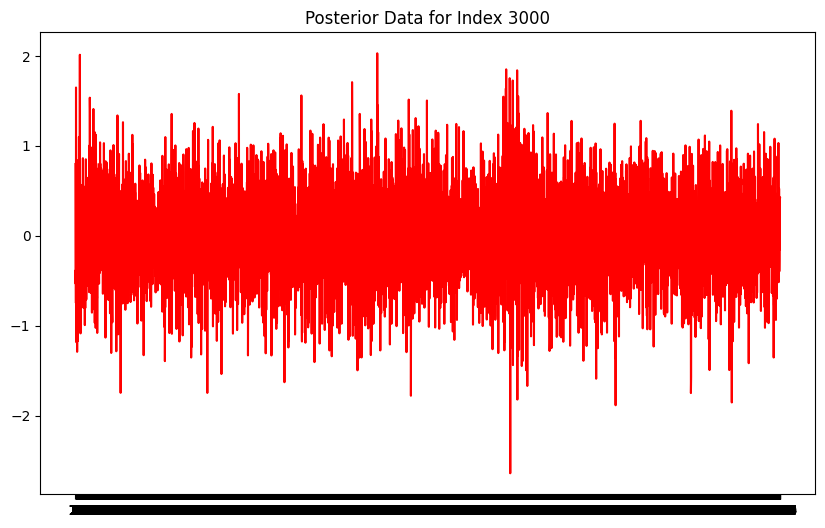

In [10]:
indices = [5, 3000]

for index in indices:
    real_sample = real_data
    post_sample = garch_y_post.iloc[index]

    # Compute statistics
    real_mean = real_sample.mean()
    real_std = real_sample.std()
    real_skew = real_sample.skew()
    real_kurt = real_sample.kurt()

    post_mean = post_sample.mean()
    post_std = post_sample.std()
    post_skew = post_sample.skew()
    post_kurt = post_sample.kurt()

    # Print statistics
    print(f"Statistics for Index {index}:")
    print("Real Data Mean: ", real_mean)
    print("Posterior Data Mean: ", post_mean)
    print("Real Data StdDev: ", real_std)
    print("Posterior Data StdDev: ", post_std)
    print("Real Data Skewness: ", real_skew)
    print("Posterior Data Skewness: ", post_skew)
    print("Real Data Kurtosis: ", real_kurt)
    print("Posterior Data Kurtosis: ", post_kurt)
    print("\n")

    # Plot histograms with KDE for real datasets overlaid
    plt.figure(figsize=(10, 6))
    sns.histplot(post_sample, kde=False, color='red', label='Posterior Data', stat="density")
    sns.kdeplot(real_sample, color='blue', label='Real Data KDE')
    plt.title(f"Histogram of Posterior Data with KDE of Real Data for Index {index}")
    plt.legend()
    plt.show()

    # Plot time series data
    plt.figure(figsize=(10, 6))
    plt.plot(real_sample, color='blue', label='Real Data')
    plt.title("Real Data")
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(post_sample, color='red', label='Posterior Data')
    plt.title(f"Posterior Data for Index {index}")
    plt.show()